# Inspect training

In [2]:
import json
from dataclasses import asdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim

import dataset.mapping

In [3]:
from dataset.datasets import get_dataset
from settings import TrainingSettings, AnnotationSettings, AudioProcessingSettings, CNNSettings, EvaluationSettings, \
    DatasetSettings
from main import train_epoch, evaluate
from model.cnn import CNN


KeyboardInterrupt



In [ ]:
training_settings: TrainingSettings = TrainingSettings(epochs=30, scheduler=False, num_workers=16)
audio_settings: AudioProcessingSettings = AudioProcessingSettings()
annotation_settings: AnnotationSettings = AnnotationSettings(time_shift=0.0)
dataset_settings = DatasetSettings(
    audio_settings=audio_settings,
    annotation_settings=annotation_settings,
)
cnn_settings = CNNSettings()
evaluation_settings = EvaluationSettings()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [ ]:
from matplotlib.colors import ListedColormap
from matplotlib import color_sequences

print(color_sequences)

colors = np.array([
    [230, 25, 75],
    [60, 180, 75],
    [255, 225, 25],
    [0, 130, 200],
    [245, 130, 48],
    [145, 30, 180],
    [70, 240, 240],
    [240, 50, 230],
    [210, 245, 60],
    [250, 190, 190],
    [0, 128, 128],
    [230, 190, 255],
    [170, 110, 40],
    [255, 250, 200],
    [128, 0, 0],
    [170, 255, 195],
    [128, 128, 0],
    [255, 215, 180],
    [0, 0, 128],
    [128, 128, 128],
    [0, 0, 0],
]) / 255
colormap = ListedColormap(colors, N=21)

# Plot a pseudo pr curve
for i in range(10):
    x = np.linspace(0, 1, 100)
    y = np.sin(x * np.pi * i) * 0.5 + 0.5
    plt.plot(x, y, color=colors[i], label=f"Class {i}")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")

In [ ]:
loader_train, loader_val, loader_test_rbma, loader_test_mdb = get_dataset(
    training_settings, audio_settings, annotation_settings
)

In [ ]:
model = CNN(**asdict(cnn_settings))
model.to(device)

In [ ]:
max_lr = training_settings.learning_rate
initial_lr = max_lr / 25
_min_lr = initial_lr / 1e4
initial_lr = (
    training_settings.learning_rate
    if not training_settings.scheduler
    else initial_lr
)
optimizer = optim.RAdam(
    model.parameters(), lr=initial_lr, weight_decay=1e-5
)
scheduler = (
    optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(loader_train),
        epochs=training_settings.epochs,
    )
    if training_settings.scheduler
    else None
)
error = torch.nn.BCEWithLogitsLoss(reduction="none")
scaler = torch.cuda.amp.GradScaler()

In [ ]:
model.to(device)
best_loss = float("inf")
best_score = 0
last_improvement = 0
for epoch in range(10):
    train_loss = train_epoch(
        epoch,
        loader_train,
        device,
        None,
        error,
        model,
        optimizer,
        scaler,
        scheduler,
        tensorboard_writer=None,
    )
    val_loss, f_score, avg_f_score = evaluate(
        epoch,
        model,
        loader_val,
        error,
        device,
        evaluation_settings.ignore_beats,
        tensorboard_writer=None,
        tag="Validation",
    )
    print(
        f"Epoch: {epoch + 1} "
        f"Loss: {train_loss * 100:.4f}\t "
        f"Val Loss: {val_loss * 100:.4f} F-Score: {avg_f_score * 100:.4f}/{f_score * 100:.4f}"
    )

In [ ]:
torch.cuda.empty_cache()
model.cpu()
loader = iter(loader_test_rbma)

In [ ]:
spec, target, annotation = next(loader)
model.eval()
with torch.no_grad():
    output = model(spec)

In [ ]:
print(output.shape)
print(target.shape)
print(spec.shape)

In [ ]:
section = range(1000, 20000)
plt.figure(figsize=(10, 10))
plt.plot(output[0][0][section].numpy(), label="Output")
plt.legend()
plt.show()

In [ ]:
section = range(1000, 20000)
plt.figure(figsize=(10, 10))
plt.plot(output[0][0][section].numpy(), label="Output")
plt.plot(target[0][0][section].numpy(), label="Target")
plt.legend()
plt.show()

In [ ]:
from model import ResidualBlock1d  # , CausalConv2d, ResidualBlock

eps = np.nextafter(np.float16(0.0), np.float16(1.0))
class_idx = 2
offset = 1
first_label = target[0][class_idx].nonzero()[15]
print(first_label)

causal_test = spec.clone()
causal_test[0, :, :first_label + offset] = 0
# causal_test[0, :, first_label+offset+30:] = 0
empty_model = ResidualBlock1d(1, 1, kernel_size=5)

model.eval()
with torch.no_grad():
    # output = model(causal_test)
    empty_output = empty_model(causal_test.unsqueeze(1)).squeeze(1)

output = empty_output

print(torch.min(output[0, class_idx, first_label - offset - 40:first_label + offset]))
print(torch.max(output[0, class_idx, first_label - offset - 40:first_label + offset]))
print(torch.min(output[0, class_idx, first_label + offset:]))
print(torch.max(output[0, class_idx, first_label + offset:]))

plt.figure(figsize=(10, 10))
plt.plot(output[0][0][first_label + offset - 10 - 1:first_label + offset + 10].numpy(), label="Output")
plt.minorticks_on()

# Test spectogram alignment

In [ ]:
import nnAudio.features
from dataset.RBMA13 import RBMA13
from dataset import load_audio
import torchaudio
import librosa
from dataset import get_time_index, get_indices

In [ ]:
rbma = RBMA13(
    path="./data/rbma_13",
    settings=dataset_settings,
    use_dataloader=False,
    is_train=False,
)

In [ ]:
mel_log, labels, gt = rbma[2]
test_audio = load_audio(rbma.get_full_path("RBMA-13-Track-03"), audio_settings.sample_rate, audio_settings.normalize)
gt = gt[2:]

In [ ]:
cqt = nnAudio.features.CQT1992v2(
    sr=audio_settings.sample_rate,
    hop_length=audio_settings.hop_size,
    fmin=20,
    fmax=20000,
    bins_per_octave=12,
    pad_mode=audio_settings.pad_mode,
)

nnAudio_stft = nnAudio.features.STFT(
    n_fft=audio_settings.fft_size,
    hop_length=audio_settings.hop_size,
    win_length=audio_settings.fft_size // 2,
    window="hann",
    center=audio_settings.center,
    pad_mode=audio_settings.pad_mode,
    trainable=False,
    output_format="Magnitude",
)

torch_stft = torchaudio.transforms.Spectrogram(
    n_fft=audio_settings.fft_size,
    hop_length=audio_settings.hop_size,
    win_length=audio_settings.fft_size // 2,
    power=2,
    center=audio_settings.center,
    pad_mode=audio_settings.pad_mode,
    normalized=True,
    onesided=True,
)

mel = torchaudio.transforms.MelScale(
    n_mels=audio_settings.n_mels,
    sample_rate=audio_settings.sample_rate,
    f_min=audio_settings.mel_min,
    f_max=audio_settings.mel_max,
    n_stft=audio_settings.fft_size // 2 + 1,
)

In [ ]:
cqt_spec = cqt(test_audio)[0]
torch_stft_spec = torch_stft(test_audio)
nnAudio_stft_spec = nnAudio_stft(test_audio)
mel_spec = mel(torch_stft_spec)
print(torch_stft_spec.shape)
print(nnAudio_stft_spec.shape)
print(cqt_spec.shape)
print(mel_spec.shape)

In [ ]:
print(torch_stft_spec.shape[-1] / audio_settings.sample_rate * audio_settings.hop_size)
print(nnAudio_stft_spec.shape[-1] / audio_settings.sample_rate * audio_settings.hop_size)
print(cqt_spec.shape[-1] / audio_settings.sample_rate * audio_settings.hop_size)
print(test_audio.shape[-1] / audio_settings.sample_rate)
print(audio_settings.fft_size // audio_settings.hop_size)

In [ ]:
plot_range = slice(000, 200)

gt_labels = [np.array(
    [label - plot_range.start / 100 for label in cls if plot_range.start <= int(label * 100) <= plot_range.stop]) for
    cls in gt]
print(gt_labels)

db = librosa.amplitude_to_db(cqt_spec[:, plot_range], ref=np.max)
fig, ax = plt.subplots(nrows=3)
_img1 = librosa.display.specshow(
    db,
    y_axis='cqt_hz',
    x_axis='time',
    ax=ax[0],
    sr=audio_settings.sample_rate,
    hop_length=audio_settings.hop_size,
    fmin=20,
    fmax=20000,
)
ax[0].set(title='CQT spectrogram')

M = mel_spec[:, plot_range].detach().numpy()
M_db = librosa.power_to_db(M, ref=np.max)
_img2 = librosa.display.specshow(
    M_db,
    y_axis='mel',
    x_axis='time',
    ax=ax[1],
    sr=audio_settings.sample_rate,
    hop_length=audio_settings.hop_size,
    fmin=audio_settings.mel_min,
    fmax=audio_settings.mel_max
)
ax[1].set(title='Mel spectrogram')

time = get_time_index(plot_range.stop - plot_range.start, audio_settings.sample_rate, audio_settings.hop_size)
time = np.array([time] * annotation_settings.n_classes).T

ax[0].vlines(time[labels[:, plot_range].T == 1], ymin=0, ymax=1)
ax[1].vlines(time[labels[:, plot_range].T == 1], ymin=0, ymax=1)
ax[2].vlines(time[labels[:, plot_range].T == 1], ymin=0, ymax=1, colors=["blue"])
for cls in gt_labels:
    ax[2].vlines(cls, ymin=0, ymax=1, colors=["red"])
ax[2].set_xlim(left=0, right=time[-1][0])
plt.tight_layout()

In [ ]:
sample_rate = audio_settings.sample_rate
hop_size = audio_settings.hop_size
fft_size = audio_settings.fft_size

for cls in gt_labels:
    if len(cls) == 0:
        continue
    index = get_indices(cls, sample_rate, hop_size)
    time = get_time_index(np.max(index) + 1, sample_rate, hop_size)
    assert np.allclose(time[index], cls,
                       atol=hop_size / sample_rate / 2), f"{time[index][np.abs(time[index] - cls) > hop_size / sample_rate / 2]} \n{cls[np.abs(time[index] - cls) > hop_size / sample_rate / 2]}"
    print()


# Test audio loading

In [ ]:
%matplotlib inline
import librosa
from dataset import load_audio, get_length
import torchaudio
import numpy as np
import torch
import matplotlib.pyplot as plt
import IPython.display as ipd

In [ ]:
def plot_audio(audio, sr, title="", offset=0, num_samples=None):
    if num_samples is None:
        num_samples = len(audio)
    t = np.arange(offset, num_samples + offset) / sr
    plt.figure(figsize=(10, 5))
    plt.plot(t, audio[offset:offset + num_samples])
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

In [ ]:
audio_path = "./data/a2md_public/ytd_audio/dist0p00/ytd_audio_00040_TRVNNMF128F4285161.mp3"
sample_rate = librosa.get_samplerate(audio_path)
duration = get_length(audio_path)
print(sample_rate, duration)
segment = (12, 20)
print(segment[0] * sample_rate, segment[1] * sample_rate)

In [ ]:
import timeit

n_runs = 10

torch_time = timeit.timeit(
    lambda: torchaudio.load(audio_path, frame_offset=int(segment[0] * sample_rate),
                            num_frames=int((segment[1] - segment[0]) * sample_rate), backend="ffmpeg", normalize=True),
    number=n_runs
)

librosa_time = timeit.timeit(
    lambda: librosa.load(audio_path, sr=sample_rate, offset=segment[0], duration=segment[1] - segment[0]),
    number=n_runs
)

loader_time = timeit.timeit(
    lambda: load_audio(path=audio_path, sample_rate=sample_rate, start=segment[0], end=segment[1], normalize=False,
                       backend="sox"),
    number=n_runs
)

print(f"Loader: {loader_time:.4f} s")
print(f"Torch: {torch_time:.4f} s")
print(f"Librosa: {librosa_time:.4f} s")

In [ ]:
torch_audio = %time torchaudio.load(audio_path, frame_offset=int(segment[0] * sample_rate), num_frames=int((segment[1] - segment[0]) * sample_rate), normalize=True)[0].squeeze()
librosa_audio, _ = %time librosa.load(audio_path, sr=sample_rate, offset=segment[0], duration=segment[1] - segment[0])
loader_audio = %time load_audio(path=audio_path, sample_rate=sample_rate, start=segment[0], end=segment[1], normalize=False)

In [ ]:
ref_index = np.argmax(np.abs(librosa_audio))
other_ref_index = torch.argmax(torch.abs(torch_audio)).item()
if ref_index != other_ref_index:
    print(ref_index, other_ref_index)

index = torch.argmax(torch.abs(loader_audio)).item()
actual_offset = index - ref_index
print(actual_offset)
print(actual_offset / sample_rate)

In [ ]:
print(loader_audio.shape, loader_audio.dtype)
print(torch_audio.shape, torch_audio.dtype)
print(librosa_audio.shape, librosa_audio.dtype)

In [ ]:
print(torch.max(loader_audio).item(), torch.min(loader_audio).item())
print(torch.max(torch_audio).item(), torch.min(torch_audio).item())
print(np.max(librosa_audio), np.min(librosa_audio))
print()

difference = loader_audio.shape[-1] - torch_audio.shape[-1]
if difference != 0:
    print(f"Loader audio is longer by {difference} samples")
    # loader_audio = loader_audio[difference:]

if not np.allclose(librosa_audio, torch_audio.numpy(), atol=1e-5):
    print(f"Librosa and torch audio are not equal")
    print(np.max(np.abs(librosa_audio - torch_audio.numpy())))
if not np.allclose(loader_audio.numpy(), torch_audio.numpy(), atol=1e-5):
    print(f"Loader and torch audio are not equal")
    print(np.max(np.abs(loader_audio.numpy() - torch_audio.numpy())))
if not np.allclose(loader_audio, librosa_audio, atol=1e-5):
    print(f"Loader and librosa audio are not equal")
    print(np.max(np.abs(loader_audio.numpy() - librosa_audio)))

In [ ]:
abs_error = 1e-4
mask = (~(np.isclose(loader_audio.numpy(), librosa_audio, atol=abs_error))).nonzero()
print(mask, len(mask[0]))
errors = loader_audio[~np.isclose(loader_audio.numpy(), librosa_audio, atol=abs_error)]
print(errors.shape, errors.shape[-1] / loader_audio.shape[-1])

In [ ]:
if difference > 0:
    extra_audio = loader_audio[:difference]
    extra_audio = extra_audio / torch.max(extra_audio)
    ipd.Audio(extra_audio, rate=sample_rate)

In [ ]:
num_samples = 800
offset = 0

In [ ]:
plot_audio(loader_audio, sample_rate, "Loader audio", num_samples=num_samples, offset=offset)
plot_audio(torch_audio.numpy(), sample_rate, "Torch audio", num_samples=num_samples, offset=offset)
plot_audio(librosa_audio, sample_rate, "Librosa audio", num_samples=num_samples, offset=offset)

In [ ]:
ipd.Audio(loader_audio.numpy(), rate=sample_rate)

# Dataset inspection

In [ ]:
from pretty_midi import PrettyMIDI
import pretty_midi
import numpy as np
from dataset.A2MD import get_tracks

In [ ]:
midi = PrettyMIDI("./data/a2md_public/align_mid/dist0p00/align_mid_00012_TRYIYUF128F932573D.mid")

In [ ]:
def get_drum_pitch_velocity(_midi: PrettyMIDI) -> np.ndarray:
    drum_instruments: list[pretty_midi.Instrument] = [
        instrument for instrument in _midi.instruments if instrument.is_drum
    ]
    notes = np.array(
        [
            (note.pitch, note.velocity)
            for instrument in drum_instruments
            for note in instrument.notes
        ]
    )
    return notes


np.array(drum_instruments[0])
# np.unique(notes[:, 0].astype(int), return_counts=True)

# Inspect trained model

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataset.RBMA13 import RBMA13
from dataset.A2MD import A2MD
from settings import DatasetSettings, CNNMambaSettings, TrainingSettings, CNNSettings, CNNAttentionSettings
from dataclasses import asdict
import dataset
from evallib import peak_pick_max_mean, calculate_pr

from model.CRNN import CRNN
from model.unet import UNet
from model.cnnM2 import CNNMambaFast
from model.cnnM import CNNMamba
from model.cnnA import CNNAttention

In [2]:
checkpoint = torch.load("../models/Jul06_14-22-00_marclie-desktop_mamba_fast_81.15.pt", map_location=torch.device("cpu"))

In [3]:
torch.cuda.empty_cache()
dataset_settings = DatasetSettings.from_flat_dict(checkpoint["dataset_settings"])
dataset_settings.segment_type = None
training_settings = TrainingSettings.from_flat_dict(checkpoint["training_settings"])
model_settings = training_settings.get_model_settings_class().from_flat_dict(checkpoint["model_settings"])
match training_settings.model_settings:
    case "cnn":
        model = CNN(**asdict(model_settings), n_classes=dataset_settings.annotation_settings.n_classes,
                    n_mels=checkpoint["dataset_settings"]["n_mels"])
    case "cnn_attention":
        model = CNNAttention(**asdict(model_settings), n_classes=dataset_settings.annotation_settings.n_classes,
                             n_mels=checkpoint["dataset_settings"]["n_mels"])
    case "mamba":
        model = CNNMamba(**asdict(model_settings), n_classes=dataset_settings.annotation_settings.n_classes,
                         n_mels=checkpoint["dataset_settings"]["n_mels"])
    case "mamba_fast":
        model = CNNMambaFast(**asdict(model_settings), n_classes=dataset_settings.annotation_settings.n_classes,
                             n_mels=checkpoint["dataset_settings"]["n_mels"])
    case "unet":
        model = UNet(**asdict(model_settings))
    case "crnn":
        model = CRNN(**asdict(model_settings), n_classes=dataset_settings.annotation_settings.n_classes,
                     n_mels=checkpoint["dataset_settings"]["n_mels"])
    case _:
        raise ValueError("Invalid model setting")
model.load_state_dict(checkpoint["model"])
model = model.eval()

In [12]:
# Calculate weight stats
def get_weight_stats(model: torch.nn.Module):
    weights = []
    for name, param in model.named_parameters():
        if "weight" in name:
            weights.append(param.data.flatten())
    weights = torch.cat(weights, dim=0)
    return {
        "mean": weights.mean().item(),
        "std": weights.std().item(),
        "min": weights.min().item(),
        "max": weights.max().item(),
    }

print(get_weight_stats(model))
print(torch.nextafter(torch.tensor(0.0, dtype=torch.float16), torch.tensor(1.0, dtype=torch.float16)), torch.nextafter(torch.tensor(0.0, dtype=torch.bfloat16), torch.tensor(1.0, dtype=torch.bfloat16)))
print(torch.finfo(torch.float16).max, torch.finfo(torch.bfloat16).max)

{'mean': 0.00033131445525214076, 'std': 0.04683024436235428, 'min': -0.9670994877815247, 'max': 1.0618863105773926}
tensor(5.9605e-08, dtype=torch.float16) tensor(9.1835e-41, dtype=torch.bfloat16)
65504.0 3.3895313892515355e+38


In [ ]:
training_settings

In [ ]:
rbma = RBMA13(
    path="../data/rbma_13",
    settings=dataset_settings,
    use_dataloader=True,
    is_train=False,
    segment=False,
)

rbma_loader = dataset.get_dataloader(rbma, 1, 1, is_train=False)

a2md = A2MD(
    path="data/a2md_public",
    settings=dataset_settings,
    use_dataloader=False,
    is_train=False,
    segment=False,
)

In [ ]:
mel_log, labels, gt = next(iter(rbma_loader))
print(mel_log.shape, labels.shape, len(gt[0]))
gt = gt[0][2:]

In [ ]:
next(iter(rbma_loader))

In [ ]:
model = model.cuda()
output: torch.Tensor = model(mel_log.cuda()).detach().cpu().sigmoid().squeeze(0)
print(output.shape)

In [ ]:
peaks = peak_pick_max_mean(output.unsqueeze(0), dataset_settings.audio_settings.sample_rate, dataset_settings.audio_settings.hop_size, dataset_settings.audio_settings.fft_size)
for cls in peaks:
    for peak in cls:
        peak[0] -= dataset_settings.annotation_settings.time_shift
_, _, _, score_sum, score_avg, _ = calculate_pr(peaks, [gt], detection_window=0.025)
score_avg, score_sum

In [ ]:
model = model.cuda()
with torch.inference_mode():
    segment = mel_log[..., 6200:7000]
    print(segment.min(), segment.max())
    segment = segment.cuda()
    # for some reason, the output is dependent on the segment length
    expected_output = model(segment)[..., :400].detach().cpu().squeeze(0)
    # plt.plot(expected_output[0].numpy(), scaley=False)
    for i in range(100):
        # segment = (torch.rand_like(segment) * 8 + 1).log()
        random = (torch.rand_like(segment) * 8 + 1).log()
        in_seg = torch.concatenate([segment, random], dim=-1)
        out_mixed = model(in_seg)[..., :400].detach().cpu().squeeze(0)
        # plt.plot((out_mixed - expected_output).abs()[0].numpy(), scaley=True)
        # assert torch.allclose(expected_output, out_clean, atol=1e-7), f"{(out_clean - expected_output).abs().sum().item(), (out_clean - expected_output).argmax(dim=-1)}"
        assert torch.allclose(out_mixed, expected_output,
                              atol=1e-9), f"{(out_mixed - expected_output).abs().sum().item(), (out_mixed - expected_output).argmax(dim=-1)}"

In [ ]:
gt_labels = dataset.get_labels(gt, dataset_settings.audio_settings.sample_rate, dataset_settings.audio_settings.hop_size, labels.shape[-1])
plt.plot(output[0, 7230:7230 + 10].numpy(), scaley=False)
plt.plot(labels[0, 0, 7230:7230 + 10].numpy(), scaley=False)
plt.plot(gt_labels[0, 7230:7230 + 10].numpy(), scaley=False)

In [ ]:
num_pos, num_neg = a2md.get_sample_distribution()
# weights according to https://markcartwright.com/files/cartwright2018increasing.pdf section 3.4.1 Task weights
total = (num_pos + num_neg)[0]
print(num_pos)
p_i = num_pos / (total * dataset_settings.annotation_settings.n_classes)
weight = 1 / (-p_i * p_i.log() - (1 - p_i) * (1 - p_i).log())
weight

# Test Causal Blocks

In [ ]:
import torch
from model import CausalAvgPool1d, CausalConv1d, CausalConv2d, CausalMaxPool1d, ResidualBlock
from model.cnn_feature import CNNFeature
from functools import partial

In [ ]:
blocks_to_test = [
    partial(torch.nn.Conv2d, 100, 32, 1),
    partial(torch.nn.MaxPool2d, kernel_size=(2, 1), stride=(2, 1)),
    partial(torch.nn.Dropout2d, 0.3),
    partial(ResidualBlock, 100, 10, 3),
    partial(CNNFeature, num_channels=16, n_layers=2, down_sample_factor=2, channel_multiplication=2, activation=torch.nn.ReLU(), causal=True, dropout=0.3, in_channels=100)
]

In [ ]:
torch.use_deterministic_algorithms(True)
compare_size = 64
for block in blocks_to_test:
    mod = block().eval()
    print(f"Testing: {mod.__class__}")
    for name, param in mod.named_parameters():
        # Set weights to one
        if 'weight' in name:
              param.data = torch.ones_like(param)
        elif 'bias' in name:
              param.data = torch.ones_like(param)
    with torch.inference_mode():
        for i in range(100):
            a = torch.rand(1, 100, 10, compare_size)
            b = torch.concatenate([a, torch.rand_like(a)[..., :]], dim=-1)
            assert (mod(a)[..., :compare_size] == mod(b)[..., :compare_size]).all(), f"Error in iteration {i}: {(mod(a)[..., :compare_size] - mod(b)[..., :compare_size]).abs().sum()}"

# Learning rate finder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataclasses import asdict


from dataset.datasets import get_dataset
from hyperparameters import final_experiment_params
from settings import Config
from model.CRNN import CRNN
from model.unet import UNet
from model.cnnM2 import CNNMambaFast
from model.cnnM import CNNMamba
from model.cnnA import CNNAttention

from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


In [ ]:
import os

os.chdir("..")
# get the current working directory
current_working_directory = os.getcwd()
current_working_directory

In [ ]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return batch_data[0], batch_data[1]

class CustomValIter(ValDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return batch_data[0], batch_data[1]

In [ ]:
config = Config.from_flat_dict(final_experiment_params["Mamba fast"])

model_settings = config.model
match config.training.model_settings:
    case "cnn":
        model = CNN(**asdict(model_settings), n_classes=config.dataset.annotation_settings.n_classes,
                    n_mels=config.dataset.audio_settings.n_mels)
    case "cnn_attention":
        model = CNNAttention(**asdict(model_settings), n_classes=config.dataset.annotation_settings.n_classes,
                             n_mels=config.dataset.audio_settings.n_mels)
    case "mamba":
        model = CNNMamba(**asdict(model_settings), n_classes=config.dataset.annotation_settings.n_classes,
                         n_mels=config.dataset.audio_settings.n_mels)
    case "mamba_fast":
        model = CNNMambaFast(**asdict(model_settings), n_classes=config.dataset.annotation_settings.n_classes,
                             n_mels=config.dataset.audio_settings.n_mels)
    case "unet":
        model = UNet(**asdict(model_settings))
    case "crnn":
        model = CRNN(**asdict(model_settings), n_classes=config.dataset.annotation_settings.n_classes,
                     n_mels=config.dataset.audio_settings.n_mels)
    case _:
        raise ValueError("Invalid model setting")

In [ ]:
config.training.dataset_version = "S"
config.training.test_sets = ()

train_loader, val_loader, _ = get_dataset(config.training, config.dataset)

In [ ]:
model = model.cuda()

optimizer = optim.RAdam(
    model.parameters(),
    lr=config.training.learning_rate,
    betas=(config.training.beta_1, config.training.beta_2),
    weight_decay=config.training.weight_decay,
    decoupled_weight_decay=config.training.decoupled_weight_decay,
    eps=config.training.epsilon,
)
criterion = nn.BCEWithLogitsLoss()

amp_config = {
    'device_type': 'cuda',
    'dtype': torch.float16,
}
grad_scaler = torch.amp.GradScaler("cuda")


In [ ]:
lr_finder = LRFinder(
    model, optimizer, criterion, device='cuda',
    amp_backend='torch', amp_config=amp_config, grad_scaler=grad_scaler
)
lr_finder.range_test(train_loader, val_loader=val_loader, start_lr=1e-6, end_lr=0.1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
plt.plot(range(10))
plt.show()

# Use Metadata from external Sources

In [1]:
from dataset.A2MD import get_tracks
import polars as pl
import json

In [2]:
def get_metadata(file: str):
    with open(f"../metadata/{file}.json", "r") as f:
        parsed = json.load(f)
        if parsed["status"]["msg"] != "Success":
            return None, None, None, None, None
        metadata = parsed["metadata"]["music"]
        first = metadata[0]

        if "spotify" in first["external_metadata"] and len(first["external_metadata"]["spotify"]["artists"]) > 0:
            artists = [artist["name"] for artist in first["external_metadata"]["spotify"]["artists"]]
        elif "deezer" in first["external_metadata"] and len(first["external_metadata"]["deezer"]["artists"]) > 0:
            artists = [artist["name"] for artist in first["external_metadata"]["deezer"]["artists"]]
        elif len(first["artists"]) > 0:
            artists = [artist["name"] for artist in first["artists"]]
        else:
            print("No artists found for", file)
        genres = [genre["name"] for genre in first["genres"]] if "genres" in first else []
        ytb_id = first["external_metadata"]["youtube"]["vid"] if "youtube" in first["external_metadata"] else None
        title = first["title"]
        release_date = first["release_date"] if "release_date" in first else None
        return artists, genres, title, ytb_id, release_date

get_metadata("dist0p00_00000_TRRORHF128E0786C6F")

(['Young Deenay'],
 ['Hip Hop', 'Pop'],
 'Wanna Be Your Lover - Extended Mix',
 'bT6kGVVReYI',
 '1998-06-02')

In [3]:
tracks = get_tracks("../data/a2md_public")

parsed_tracks = [tuple([folder, track]) for folder, track_list in tracks.items() for track in track_list]
df = pl.DataFrame(parsed_tracks, schema=["folder", "identifier"], orient="row")

In [4]:
df = (
    df.lazy()
    .with_columns(args=pl.concat_list(pl.col("folder") ,pl.col("identifier")).list.join("_"))
    .with_columns(pl.col("args").map_elements(get_metadata, return_dtype=pl.Object))
    .with_columns(
        artists=pl.col("args").map_elements(lambda x: x[0] if x else None, return_dtype=pl.List(pl.String)),
        genres=pl.col("args").map_elements(lambda x: x[1] if x else None, return_dtype=pl.List(pl.String)),
        title=pl.col("args").map_elements(lambda x: x[2] if x else None, return_dtype=pl.String),
        ytb_id=pl.col("args").map_elements(lambda x: x[3] if x else None, return_dtype=pl.String),
        release_date=pl.col("args").map_elements(lambda x: x[4] if x else None, return_dtype=pl.String).str.to_date(strict=False),
    )
    .drop("args")
    .collect()
)

In [5]:
df.select("folder", "identifier", "genres").explode("genres").write_csv("../data/a2md_public/genres.csv", include_header=True, separator=",")
df.select("folder", "identifier", "artists").explode("artists").write_csv("../data/a2md_public/artists.csv", include_header=True, separator=",")

In [44]:
all_artists = df.select(pl.col("artists").explode().str.to_lowercase()).unique().sort("artists").to_series().to_list()
df = (
    df.lazy()
    .explode("artists")
    .with_columns(
        artist_id=pl.col("artists").str.to_lowercase().map_elements(all_artists.index, return_dtype=pl.Int64).fill_null(0)
    )
    .group_by("folder", "identifier")
    .agg(
        "artists",
        "artist_id",
        pl.col("title").first(),
        pl.col("ytb_id").first(),
        pl.col("release_date").first(),
        pl.col("genres").first()
    )
    .collect()
)
max_id = len(all_artists)
collabs = df.filter(pl.col("artist_id").list.len() > 1).select(ids="artist_id").unique().sort("ids").to_series().to_list()
flat_ids = sorted({iden for collab in collabs for iden in collab})
groups = [collabs[0]]
unfinished = collabs[1:]
iterations_taken = 0
while True:
    for collab in unfinished:
        for i, group in enumerate(groups):
            group: list = group
            if any([iden in group for iden in collab]):
                groups[i] = list({*group, *collab})
                break
        else:
            groups.append(collab)
    if sum([len(group) for group in groups]) == len(flat_ids):
        break
    unfinished = groups[1:]
    groups = [groups[0]]
    iterations_taken += 1
group_map = {iden: [iden in group for group in groups].index(True) + max_id for iden in flat_ids}
identity = {i: i for i in range(max_id)}
identity.update(group_map)
group_map = identity

df = (
    df.lazy()
    .explode("artist_id")
    .with_columns(group=pl.col("artist_id").replace_strict(group_map))
    .group_by("folder", "identifier")
    .agg(
        pl.col("artists").first(),
        "artist_id",
        "group",
        pl.col("title").first(),
        pl.col("ytb_id").first(),
        pl.col("release_date").first(),
        pl.col("genres").first()
    )
    .collect()
)

assert df.filter(pl.col("group").list.len() > 1).select(pl.col("group").list.unique()).select(pl.col("group").list.len()).unique().select(pl.len())[0, 0] == 1, "A song is in multiple groups"

df = df.with_columns(group=pl.col("group").list.get(0))

df.select("folder", "identifier", "group").sort("identifier").write_csv("../data/a2md_public/groups.csv", include_header=True, separator=",")

NameError: name 'df' is not defined

In [8]:
df.write_parquet("../data/a2md_public/metadata.parquet", compression="gzip", compression_level=9)

In [9]:
df

folder,identifier,artists,artist_id,group,title,ytb_id,release_date,genres
str,str,list[str],list[i64],i64,str,str,date,list[str]
"""dist0p40""","""01281_TRUFCVS12903C9E728""","[""Depeche Mode""]",[180],785,"""Shout! (Live in Hammersmith)""","""a4hwQKyT_q0""",1983-01-01,"[""Rock""]"
"""dist0p40""","""01012_TRBSXPE128F1453DCE""","[""Bryan Adams""]",[118],783,"""Straight From The Heart""","""ImCTOtOJyi0""",2005-01-01,"[""Pop"", ""Rock""]"
"""dist0p50""","""01432_TRMKWQX128F4251C93""","[""Little Tony""]",[396],396,"""Ridera'""","""Dpw95LkE9Rc""",2012-10-12,"[""Pop - Italo""]"
"""dist0p40""","""01036_TRUURXI128F1494970""","[""Subsonica""]",[625],625,"""Nuova Ossessione""","""WEOGrMVRDXk""",2006-12-11,"[""Alternative"", ""Pop""]"
"""dist0p40""","""01149_TRDGCIZ128F14640CE""","[""Rose Royce""]",[559],559,"""Car Wash""","""PkxaunLybuM""",2007-01-01,"[""Pop"", ""Rock""]"
…,…,…,…,…,…,…,…,…
"""dist0p30""","""00951_TRWFHWK128F9305E83""","[""Brooks & Dunn""]",[115],115,"""Little Miss Honky Tonk""","""kCmi7RAUDno""",2012-06-12,"[""Country""]"
"""dist0p20""","""00300_TRMRHAD12903CC0130""","[""Michael Bublé""]",[445],445,"""Haven't Met You Yet""","""1AJmKkU5POA""",2009-10-06,"[""Pop""]"
"""dist0p40""","""01293_TRWMAAQ128EF344587""","[""Sam & Dave""]",[571],571,"""I Thank You""",null,2018-10-19,"[""R & B""]"


# Inspect A2MD Splits

In [1]:
import os
os.chdir("..")

In [2]:
from dataset.A2MD import get_splits, get_annotation
import polars as pl
import polars.selectors as cs
from dataset.mapping import DrumMapping
from itertools import combinations
from sklearn.model_selection import KFold
import numpy as np
from typing import Iterable

In [3]:
groups = pl.read_csv("./data/a2md_public/groups.csv", separator=",", has_header=True).with_columns(group=pl.col("group").cast(pl.Int64))

In [4]:
identifiers = groups.select("folder", "identifier").unique().sort("identifier").to_dict()
annotations = {
    identifier: get_annotation("./data/a2md_public", folder, identifier, DrumMapping.THREE_CLASS) for folder, identifier in zip(identifiers["folder"], identifiers["identifier"])
}
class_names = [DrumMapping.THREE_CLASS.get_name(i) for i in range(len(DrumMapping.THREE_CLASS))]
annotations = [(identifier, *[len(ann) for ann in annotation[1]], *[len(ann) for ann in annotation[2]]) for identifier, annotation in annotations.items() if annotation is not None]
annotations = pl.DataFrame(annotations, schema=["identifier", *class_names, "down_beat", "beat"], orient="row")

In [ ]:
possible_seeds = sorted(set([get_splits("S",  [0.8, 0.2, 0.], "../data/a2md_public", seed=seed, return_seed=True)[1] for seed in range(1000)]))

In [ ]:
splits = {seed: get_splits("S", [0.8, 0.2, 0.], "../data/a2md_public", seed=seed, return_seed=False) for seed in possible_seeds}

In [3]:
def get_group(identifier: str, _groups: pl.DataFrame) -> int:
    group = _groups.lazy().filter(pl.col("identifier") == identifier).select("group").collect().to_series().to_list()
    if len(group) == 0:
        return -1
    return group[0]

In [23]:
flat_splits = [(seed, folder, identifier, "train") for seed in possible_seeds for folder, idens in splits[seed][0].items() for identifier in idens] + \
              [(seed, folder, identifier, "val") for seed in possible_seeds for folder, idens in splits[seed][1].items() for identifier in idens] + \
              [(seed, folder, identifier, "test") for seed in possible_seeds for folder, idens in splits[seed][2].items() for identifier in idens]
flat_splits = pl.DataFrame(flat_splits, schema=["seed", "folder", "identifier", "split"], orient="row")
flat_splits = flat_splits.join(groups, on=("folder", "identifier"), how="inner", validate="m:1")

In [52]:
flat_splits = flat_splits.join(annotations, on="identifier", how="inner", validate="m:1")

In [67]:
ratios = flat_splits.group_by("seed", "split").agg(
    pl.col(*class_names).sum(),
).with_columns(
    total=pl.sum_horizontal(*class_names)
).with_columns(
    (pl.col(*class_names) / pl.col("total") * 100)
).sort("seed", "split")

In [142]:
ratios.group_by("seed").agg(
    pl.col(class_names).std()
)

seed,BD,SD,HH
i64,f64,f64,f64
9,1.649048,0.345792,1.99484
12,0.807109,1.968988,1.161879
21,1.645274,0.990823,0.654451
23,3.928319,0.173146,3.755173
26,1.013447,0.581445,1.594892
…,…,…,…
975,1.81161,3.033956,1.222346
982,1.245749,0.675034,0.570715
989,1.375396,0.259135,1.116261


In [144]:
seeded_groups = flat_splits.group_by("seed", "split").agg(
    pl.col("group")
).filter(
    pl.col("split") == "val"
).select(
    "seed", "group"
).to_dict(as_series=False)
seeded_groups = zip(seeded_groups["seed"], seeded_groups["group"])
overlap_count = []
current_min = 99999999
for combination in combinations(seeded_groups, 3):
    overlapping = len(set([iden for seed, group in combination for iden in group]))
    current_min = min(current_min, overlapping)
    if overlapping < current_min * 1.05:
        overlap_count.append((*(list(zip(*combination))[0]), overlapping))

In [106]:
np.argpartition(np.array(overlap_count)[:, -1], -10)[-10:]

array([ 2, 14,  3,  7, 16,  8, 10, 11, 15,  0])

In [145]:
np.array(overlap_count)

array([[184, 952, 210,  64],
       [184, 952, 884,  64],
       [184, 952,  82,  67],
       [184, 952, 493,  67],
       [184, 952, 536,  67],
       [184, 952,  49,  66],
       [184, 952, 564,  66],
       [184, 952, 982,  62],
       [184, 952, 695,  65],
       [184, 952, 758,  65],
       [184, 952, 906,  65],
       [184, 952, 638,  65],
       [184, 952, 961,  63],
       [184, 952, 911,  64],
       [184, 952, 879,  65],
       [184, 952, 490,  65],
       [184, 952, 450,  63],
       [184, 952, 577,  65],
       [184, 952, 215,  63],
       [184, 952, 561,  65],
       [184, 952, 355,  64],
       [184, 952, 684,  64],
       [184, 952, 900,  65],
       [184, 952, 989,  65],
       [184, 952, 121,  65],
       [184, 952, 737,  62],
       [184, 952, 623,  65],
       [184, 952, 460,  64],
       [184, 952, 614,  65],
       [184, 952,  60,  64],
       [184, 952, 252,  64],
       [184, 952, 662,  61],
       [184, 952, 939,  64],
       [184, 952, 605,  64],
       [184, 9

## Create K-Fold Splits

In [30]:
group_ids = np.array(groups.select("group").unique().sort("group").to_series().to_list())

In [6]:
def count_folders(_groups: pl.DataFrame, group_ids: list[int]) -> dict[int, int]:
    folders = _groups.lazy().select("folder").unique().sort("folder").collect().to_series().to_list()
    folder_counts = {folder: 0 for folder in folders}
    for folder in folders:
        folder_counts[folder] = _groups.lazy().filter(pl.col("folder") == folder).filter(pl.col("group").is_in(group_ids)).select(pl.len()).collect().to_series().to_list()[0]
    return folder_counts

In [80]:
n_folds = 10

folder_dist = [(seed, fold, *list(count_folders(groups, group_ids[val]).values())) for seed in range(10000) for fold, (train, val) in enumerate(KFold(n_splits=n_folds, shuffle=True, random_state=seed).split(group_ids))]
folder_dist = pl.DataFrame(folder_dist, schema=["seed", "fold", *groups.select("folder").unique().sort("folder").to_series().to_list()], orient="row")

In [81]:
window_to_consider = 100
folder_deviance = (
    folder_dist.lazy()
    .group_by("seed")
    .agg(
        cs.starts_with("dist").std(),
    ).select(
        "seed",
        mean_folder_deviance=pl.mean_horizontal(cs.starts_with("dist"))
    ).sort("mean_folder_deviance")
    .head(window_to_consider)
    .with_row_index("folder_rank")
    .collect()
)
selected_seeds = folder_deviance.select("seed").to_series().to_list()

In [82]:
folder_deviance

folder_rank,seed,mean_folder_deviance
u32,i64,f64
0,7301,3.272586
1,9777,3.522954
2,4616,3.588141
3,2515,3.626523
4,3995,3.679613
…,…,…
95,6532,4.023204
96,1631,4.023393
97,662,4.025235


In [83]:
top_splits = [(seed, fold, list(group_ids[list(val)])) for seed in selected_seeds for fold, (train, val) in enumerate(KFold(n_splits=n_folds, shuffle=True, random_state=seed).split(group_ids))]
top_splits = pl.DataFrame(top_splits, schema=["seed", "fold", "groups"], orient="row").explode("groups").rename({"groups": "group"})
top_splits = top_splits.join(groups, on="group", how="right").sort("seed", "fold", "group")
top_splits = top_splits.join(annotations, on="identifier", how="inner", validate="m:1")

In [84]:
selected_groups = top_splits.select("group").unique().to_series().to_list()
set(selected_groups) ^ set(group_ids)

{50, 162}

In [85]:
class_deviance =(
    top_splits.lazy()
    .group_by("seed", "fold")
    .agg(
        pl.col(*class_names).sum(),
    ).with_columns(
        total=pl.sum_horizontal(*class_names)
    ).with_columns(
        (pl.col(*class_names) / pl.col("total") * 100)
    ).group_by("seed").agg(
        pl.col(*class_names).std(),
    ).select(
        "seed",
    mean_class_deviance=pl.mean_horizontal(*class_names)
    ).sort("mean_class_deviance")
    .with_row_index("class_rank")
    .collect()
 )
class_deviance

class_rank,seed,mean_class_deviance
u32,i64,f64
0,6276,0.746895
1,541,0.863384
2,5881,0.930949
3,546,0.959446
4,4732,1.012635
…,…,…
95,356,1.846893
96,6928,1.962526
97,4665,1.987367


In [86]:
ranking = class_deviance.join(folder_deviance, on="seed", how="inner").with_columns(
    rank=pl.col("class_rank") + pl.col("folder_rank")
).sort("rank")
ranking

class_rank,seed,mean_class_deviance,folder_rank,mean_folder_deviance,rank
u32,i64,f64,u32,f64,u32
9,3272,1.084436,6,3.708909,15
17,9777,1.136417,1,3.522954,18
0,6276,0.746895,19,3.811847,19
12,8364,1.102338,8,3.732766,20
15,956,1.110946,10,3.739863,25
…,…,…,…,…,…
82,8383,1.633806,85,4.010891,167
99,2225,2.04173,69,3.98774,168
71,4124,1.555989,99,4.026027,170


In [87]:
# final_seeds = [4785, 8957, 635] # 3 folds
# final_seeds = [7194, 1118, 758] # 5 folds
# final_seeds = [3272, 9777, 6276] # 10 folds
final_seeds = ranking.select("seed").to_series().to_list()[:3]

In [88]:
for i, seed in enumerate(final_seeds):
    top_splits.filter(pl.col("seed") == seed).select("folder", "identifier", "fold").sort("fold", "identifier").write_csv(f"../data/a2md_public/splits_{n_folds}-folds_{i}.csv", include_header=True, separator=",")

In [5]:
group_ids = np.array(groups.select("group").unique().sort("group").to_series().to_list())

In [14]:
def get_top_seeds(ids: np.ndarray, n_folds: int, search_space: Iterable[int], n_seeds=10, min_rank=1000) -> list[int]:
    splits = [(seed, fold, list(ids[list(val)])) for seed in search_space for fold, (_, val) in enumerate(KFold(n_splits=n_folds, shuffle=True, random_state=seed).split(ids))]
    splits = pl.DataFrame(splits, schema=["seed", "fold", "groups"], orient="row").explode("groups").rename({"groups": "group"})

    folder_deviance = (
        splits.lazy().join(
            groups.lazy(),
            on="group",
            how="inner",
        )
        .group_by("seed", "fold", "folder")
        .agg(
            pl.col("identifier").count().alias("count")
        )
        .group_by("seed", "folder")
        .agg(
            pl.col("count").std()
        )
        .group_by("seed")
        .agg(
            pl.col("count").mean().alias("mean_folder_deviance")
        )
        # center around 1 to make it easier to compare
        .with_columns(
            pl.col("mean_folder_deviance") / pl.col("mean_folder_deviance").mean()
        )
        .sort("mean_folder_deviance")
        .head(min_rank)
        .with_row_index("folder_rank")
    )

    folder_aggregate = (
        splits.lazy()
        .join(
            groups.lazy(),
            on="group",
            how="inner",
        )
        .join(
            annotations.lazy(),
            on="identifier",
            how="inner",
            validate="m:1"
        )
        .group_by("seed", "fold", "folder")
        .agg(
            pl.col(*class_names).sum()
        )
    )

    folders = folder_aggregate.select("folder").unique().sort("folder").collect().to_series().to_list()
    folder_subsets = []
    for i, folder in enumerate(folders):
        folder_subsets.append(folders[:i + 1])

    subset_ranks = []

    for i, subset in enumerate(folder_subsets):
        subset_ranking = (
            folder_aggregate
            .filter(pl.col("folder").is_in(subset))
            .group_by("seed", "fold")
            .agg(
                pl.col(*class_names).sum(),
            )
            .with_columns(
                total=pl.sum_horizontal(*class_names)
            ).with_columns(
                (pl.col(*class_names) / pl.col("total") * 100)
            )
            .group_by("seed")
            .agg(
                pl.col(*class_names).std(),
            )
            .select(
                "seed",
                pl.mean_horizontal(*class_names).alias(f"mean_class_deviance_{i}"),
            )
        )
        subset_ranks.append(subset_ranking)

    subset_ranking = subset_ranks[0]
    for i in range(1, len(subset_ranks)):
        subset_ranking = subset_ranking.join(
            subset_ranks[i],
            on="seed",
            how="inner"
        )

    subset_ranking = (
        subset_ranking.with_columns(
            mean_subset_deviance=pl.mean_horizontal(cs.starts_with("mean_class_deviance_"))
        )
        .sort("mean_subset_deviance")
        .with_columns(
            pl.col("mean_subset_deviance") / pl.col("mean_subset_deviance").mean()
        )
        .head(min_rank).with_row_index("subset_rank")# center around 1 to make it easier to compare

    )


    total_class_deviance = (
        folder_aggregate.lazy()
        .group_by("seed", "fold")
        .agg(
            pl.col(*class_names).sum(),
        )
        .with_columns(
            total=pl.sum_horizontal(*class_names)
        ).with_columns(
            (pl.col(*class_names) / pl.col("total") * 100)
        )
        .group_by("seed")
        .agg(
            pl.col(*class_names).std(),
        )
        .select(
            "seed",
            mean_class_deviance=pl.mean_horizontal(*class_names)
        )
        # center around 1 to make it easier to compare
        .with_columns(
            pl.col("mean_class_deviance") / pl.col("mean_class_deviance").mean()
        )
        .sort("mean_class_deviance")
        .head(min_rank)
        .with_row_index("total_class_rank")
    )

    # folder_class_deviance = (
    #     folder_aggregate.lazy()
    #     .with_columns(
    #         total=pl.sum_horizontal(*class_names)
    #     ).with_columns(
    #         (pl.col(*class_names) / pl.col("total") * 100)
    #     )
    #     .group_by("seed", "folder")
    #     .agg(
    #         pl.col(*class_names).std(),
    #     )
    #     .select(
    #         "seed",
    #         "folder",
    #         mean_class_deviance=pl.mean_horizontal(*class_names)
    #     )
    #     .with_columns(
    #         weight=pl.col("folder").replace_strict({
    #             "dist0p00": 7,
    #             "dist0p10": 6,
    #             "dist0p20": 5,
    #             "dist0p30": 4,
    #             "dist0p40": 3,
    #             "dist0p50": 2,
    #             "dist0p60": 1,
    #         }, return_dtype=pl.Int8)
    #     )
    #     .with_columns(
    #         # weigh earlier folders more, because they get combined cumulatively
    #         mean_class_deviance=pl.col("mean_class_deviance") * pl.col("weight")
    #     )
    #     .group_by("seed")
    #     .agg(
    #         folder_class_deviance=pl.col("mean_class_deviance").mean(),
    #     )
    #     # center around 1 to make it easier to compare
    #     .with_columns(
    #         pl.col("folder_class_deviance") / pl.col("folder_class_deviance").mean()
    #     )
    #     .sort("folder_class_deviance")
    #     .head(min_rank)
    #     .with_row_index("folder_class_rank")
    # )

    ranking = (
        folder_deviance
        .join(
            total_class_deviance,
            on="seed",
            how="inner"
        )
        .join(
            subset_ranking,
            on="seed",
            how="inner"
        )
        .with_columns(
            deviance_score=(
                pl.col("mean_folder_deviance")
                +
                pl.col("mean_class_deviance")
                +
                pl.col("mean_subset_deviance") * 2
            )
        )
        .select("seed", "deviance_score", pl.exclude("seed", "deviance_score"))
        .sort("deviance_score")
        .head(n_seeds)
    )

    return ranking.collect(engine="streaming")

In [15]:
best_seeds = {}
for n_folds in [3, 5, 10]:
    print(n_folds)
    best_seeds[n_folds] = get_top_seeds(group_ids, n_folds, range(100_000), n_seeds=10, min_rank=5000)

3
5
10


In [16]:
best_seeds[3]

seed,deviance_score,folder_rank,mean_folder_deviance,total_class_rank,mean_class_deviance,subset_rank,mean_class_deviance_0,mean_class_deviance_1,mean_class_deviance_2,mean_class_deviance_3,mean_class_deviance_4,mean_class_deviance_5,mean_class_deviance_6,mean_subset_deviance
i64,f64,u32,f64,u32,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64
94895,1.702761,344,0.490148,3308,0.361369,71,0.598833,1.263525,0.813471,0.320312,0.318101,0.276931,0.257266,0.425622
50039,1.866371,1633,0.580937,998,0.259376,595,2.030996,1.080875,0.436978,0.358341,0.262185,0.28474,0.184655,0.513029
1490,1.8795,2057,0.596414,912,0.253699,612,1.604316,1.472584,0.500296,0.397315,0.334284,0.164411,0.180613,0.514693
15162,1.887801,1732,0.584663,4275,0.388349,163,1.002689,1.484428,0.212103,0.449707,0.337842,0.372491,0.276473,0.457395
4732,1.892205,2158,0.599995,653,0.231879,856,0.93727,2.400932,0.368104,0.287525,0.376499,0.258312,0.165079,0.530166
51394,1.915128,2469,0.609825,346,0.198625,1337,2.51763,1.531802,0.414644,0.214459,0.079147,0.104165,0.141405,0.553339
64202,1.921316,519,0.511432,4617,0.397055,513,1.448758,1.074584,0.262093,0.729594,0.496287,0.284975,0.282671,0.506414
5675,1.930008,2956,0.623396,269,0.188926,1476,2.734024,1.053665,0.609167,0.14511,0.136142,0.240411,0.1345,0.558843
15014,1.940974,4269,0.651053,456,0.212434,1021,0.731386,1.701834,0.914443,0.768047,0.312156,0.292176,0.151235,0.538743


In [17]:
best_seeds[5]

seed,deviance_score,folder_rank,mean_folder_deviance,total_class_rank,mean_class_deviance,subset_rank,mean_class_deviance_0,mean_class_deviance_1,mean_class_deviance_2,mean_class_deviance_3,mean_class_deviance_4,mean_class_deviance_5,mean_class_deviance_6,mean_subset_deviance
i64,f64,u32,f64,u32,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64
67923,2.136737,5,0.49625,100,0.306103,1433,3.567983,2.624187,0.85951,0.548142,0.238863,0.204413,0.298741,0.667192
98855,2.180626,2260,0.715575,280,0.354016,73,2.493609,1.85792,0.800839,0.652321,0.425232,0.370159,0.345501,0.555518
59146,2.229713,3138,0.733257,251,0.34774,139,2.512905,1.755422,1.114968,0.800645,0.327424,0.330401,0.339376,0.574358
51354,2.24625,1523,0.695071,360,0.366814,242,3.348505,1.573357,1.01614,0.528006,0.328249,0.251748,0.357991,0.592182
80159,2.32185,3254,0.735158,1,0.182894,2821,4.454881,2.249029,1.072605,0.478636,0.206461,0.135663,0.178495,0.701899
17481,2.332167,574,0.648698,304,0.359539,1305,4.391789,1.427595,0.775338,0.496288,0.453882,0.380701,0.350892,0.661965
68350,2.333815,1484,0.693887,776,0.413875,414,2.872635,2.283915,0.713226,0.510973,0.398792,0.481142,0.403921,0.613026
64844,2.352284,109,0.587587,4107,0.540997,403,3.508559,1.180676,1.053092,0.480457,0.447643,0.451491,0.527985,0.61185
24581,2.35859,582,0.649823,306,0.360297,1661,3.603078,1.611364,1.178087,0.849644,0.407783,0.428304,0.351632,0.674235


In [18]:
best_seeds[10]

seed,deviance_score,folder_rank,mean_folder_deviance,total_class_rank,mean_class_deviance,subset_rank,mean_class_deviance_0,mean_class_deviance_1,mean_class_deviance_2,mean_class_deviance_3,mean_class_deviance_4,mean_class_deviance_5,mean_class_deviance_6,mean_subset_deviance
i64,f64,u32,f64,u32,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64
79302,2.655952,269,0.740298,285,0.537773,264,4.78416,2.81138,1.963535,1.035573,0.764032,0.773063,0.767518,0.688941
46825,2.714891,1821,0.800024,183,0.518278,369,4.927143,2.950018,1.802143,1.158179,0.764175,0.733041,0.739695,0.698295
60889,2.717431,1937,0.802663,249,0.532162,289,4.672079,3.422384,1.420177,0.921185,0.873456,0.874691,0.759511,0.691303
41037,2.735955,2040,0.804924,4793,0.694417,9,3.995289,2.975583,1.299756,0.772878,0.627506,0.914659,0.991084,0.618307
31980,2.737204,257,0.738957,65,0.480305,2183,6.071442,2.864615,1.61451,1.118935,1.044858,0.810598,0.6855,0.758971
81940,2.751996,4275,0.834757,1807,0.629317,42,4.247807,2.47497,1.371406,1.073789,0.951256,1.039697,0.898172,0.643961
8860,2.76974,3496,0.825902,1650,0.62368,82,5.001753,2.459833,1.178401,1.099358,0.9074,0.822,0.890126,0.660079
83175,2.772345,89,0.712674,460,0.557061,1832,4.330474,4.086878,1.843472,1.260041,0.936918,0.81409,0.795047,0.751305
31574,2.801304,1136,0.783613,779,0.58225,670,5.267625,3.066416,1.404599,1.021452,0.954988,0.89204,0.830996,0.717721


In [19]:
for k_fold, seeds in best_seeds.items():
    for i, seed in enumerate(seeds.select("seed").to_series().to_list()[:3]):
        split = [(fold, list(group_ids[list(val)])) for fold, (_, val) in enumerate(KFold(n_splits=n_folds, shuffle=True, random_state=seed).split(group_ids))]
        split = (
            pl.DataFrame(split, schema=["fold", "groups"], orient="row")
            .explode("groups")
            .rename({"groups": "group"})
            .join(
                groups,
                on="group",
                how="inner"
            )
            .drop("group")
            .sort("fold", "identifier")
        )
        split.write_csv(f"./data/a2md_public/splits_{k_fold}-folds_{i+3}.csv", include_header=True, separator=",")

# A2MD Genre Analysis


In [117]:
from itertools import combinations

import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [138]:
genres = pl.read_csv("../data/a2md_public/genres.csv", separator=",", has_header=True).fill_null("Unknown")

In [139]:
mapped_genres = (
    genres.with_columns(
        pl.col("genres").alias("genre"),
        pl.col("genres")
        .str.to_lowercase()
    )
    .with_columns(
        pl.when(
            pl.col("genres").str.contains("rock") |
            pl.col("genres").str.contains("punk") |
            pl.col("genres").str.contains("metal") |
            pl.col("genres").str.contains("grunge") |
            pl.col("genres").str.contains("gothic") |
            pl.col("genres").str.contains("alternative")
        )
        .then(pl.lit("Rock"))
        .otherwise(pl.col("genres"))
        .alias("genres")
    )
    .with_columns(
        pl.when(
            pl.col("genres").str.contains("r&b") |
            pl.col("genres").str.contains("r & b") |
            pl.col("genres").str.contains("hop") |
            pl.col("genres").str.contains("soul") |
            pl.col("genres").str.contains("funk") |
            pl.col("genres").str.contains("rap") |
            pl.col("genres").str.contains("adult contemporary") |
            pl.col("genres").str.contains("gospel") |
            pl.col("genres").str.contains("christian")
        )
        .then(pl.lit("R&B/Hip Hop"))
        .otherwise(pl.col("genres"))
        .alias("genres")
    )
    .with_columns(
        pl.when(
            pl.col("genres").str.contains("electro") |
            pl.col("genres").str.contains("dance") |
            pl.col("genres").str.contains("house") |
            pl.col("genres").str.contains("techno") |
            pl.col("genres").str.contains("disco")
        )
        .then(pl.lit("Dance/Electronic"))
        .otherwise(pl.col("genres"))
        .alias("genres")
    )
    # .with_columns(
    #     pl.when(
    #         pl.col("genres").str.contains("gospel") |
    #         pl.col("genres").str.contains("christian") |
    #         pl.col("genres").str.contains("religious")
    #     )
    #     .then(pl.lit("Religious"))
    #     .otherwise(pl.col("genres"))
    #     .alias("genres")
    # )
    .with_columns(
        pl.when(
            pl.col("genres").str.contains("film") |
            pl.col("genres").str.contains("game") |
            pl.col("genres").str.contains("score") |
            pl.col("genres").str.contains("soundtrack") |
            pl.col("genres").str.contains("musical") |
            pl.col("genres").str.contains("classical") |
            pl.col("genres").str.contains("orchestra") |
            pl.col("genres").str.contains("opera")
        )
        .then(pl.lit("Soundtrack/Classical"))
        .otherwise(pl.col("genres"))
        .alias("genres")
    )
    .with_columns(
        pl.when(
            pl.col("genres").str.contains("jazz") |
            pl.col("genres").str.contains("blues") |
            pl.col("genres").str.contains("swing")
        )
        .then(pl.lit("Jazz"))
        .otherwise(pl.col("genres"))
        .alias("genres")
    )
    .with_columns(
        pl.when(
            pl.col("genres").str.contains("country") |
            pl.col("genres").str.contains("bluegrass") |
            pl.col("genres").str.contains("folk") |
            pl.col("genres").str.contains("volk") |
            pl.col("genres").str.contains("children’s music") |
            pl.col("genres").str.contains("religious")
        )
        .then(pl.lit("Folk"))
        .otherwise(pl.col("genres"))
        .alias("genres")
    )
    .with_columns(
        pl.when(
            pl.col("genres").str.contains("reggae") |
            pl.col("genres").str.contains("latin") |
            pl.col("genres").str.contains("carribean") |
            pl.col("genres").str.contains("world") |
            pl.col("genres").str.contains("afro") |
            pl.col("genres").str.contains("south america") |
            pl.col("genres").str.contains("central america") |
            pl.col("genres").str.contains("ital") |
            pl.col("genres").str.contains("europe")
        )
        .then(pl.lit("World"))
        .otherwise(pl.col("genres"))
        .alias("genres")
    )
    .with_columns(
        pl.when(
            pl.col("genres").str.contains("pop")
        )
        .then(pl.lit("Pop"))
        .otherwise(pl.col("genres"))
        .alias("genres")
    )
    .with_columns(
        pl.when(
            pl.col("genres").str.contains("unknown") |
            (pl.col("genres") == "miscellaneous")
        )
        .then(pl.lit("Unknown"))
        .otherwise(pl.col("genres"))
        .alias("genres")
    )
    .with_columns(
        mapped_genre=pl.col("genres")
    )
    .drop("genres")
    # .unique(["folder", "identifier", "mapped_genre"])
)

In [140]:
genre_count = mapped_genres.select("mapped_genre").group_by("mapped_genre").agg(count=pl.len()).sort("count", descending=True)
genres_with_count = mapped_genres.join(genre_count, on="mapped_genre", how="left")

genres_with_count.filter(pl.col("mapped_genre") == "Folk").select("genre").unique().sort("genre")

genre
str
"""Bluegrass"""
"""Children’s Music"""
"""Country"""
"""Folk"""
"""Indie Pop/Folk"""
"""Schlager/Volksmusik"""


In [141]:
genre_count

mapped_genre,count
str,u32
"""Rock""",1005
"""Pop""",977
"""R&B/Hip Hop""",198
"""Dance/Electronic""",150
"""Folk""",149
"""World""",115
"""Unknown""",71
"""Soundtrack/Classical""",36
"""Jazz""",20


In [142]:
all_genres = genre_count.sort("count", descending=True).select("mapped_genre").to_series().to_list()
all_genres.remove("Unknown")
all_genres = all_genres + ["Unknown"]
co_occurrence_matrix = np.zeros((len(all_genres), len(all_genres)), dtype=int)

genre_list = mapped_genres.group_by("identifier").agg(
    pl.col("mapped_genre").unique().alias("genres")
).select("genres").to_series().to_list()
for genres in genre_list:
    if len(genres) == 1:
        co_occurrence_matrix[all_genres.index(genres[0]), all_genres.index(genres[0])] += 1
        continue
    for genre_a, genre_b in combinations(genres, 2):
        idx_a = all_genres.index(genre_a)
        idx_b = all_genres.index(genre_b)
        co_occurrence_matrix[idx_a, idx_b] += 1
        co_occurrence_matrix[idx_b, idx_a] += 1


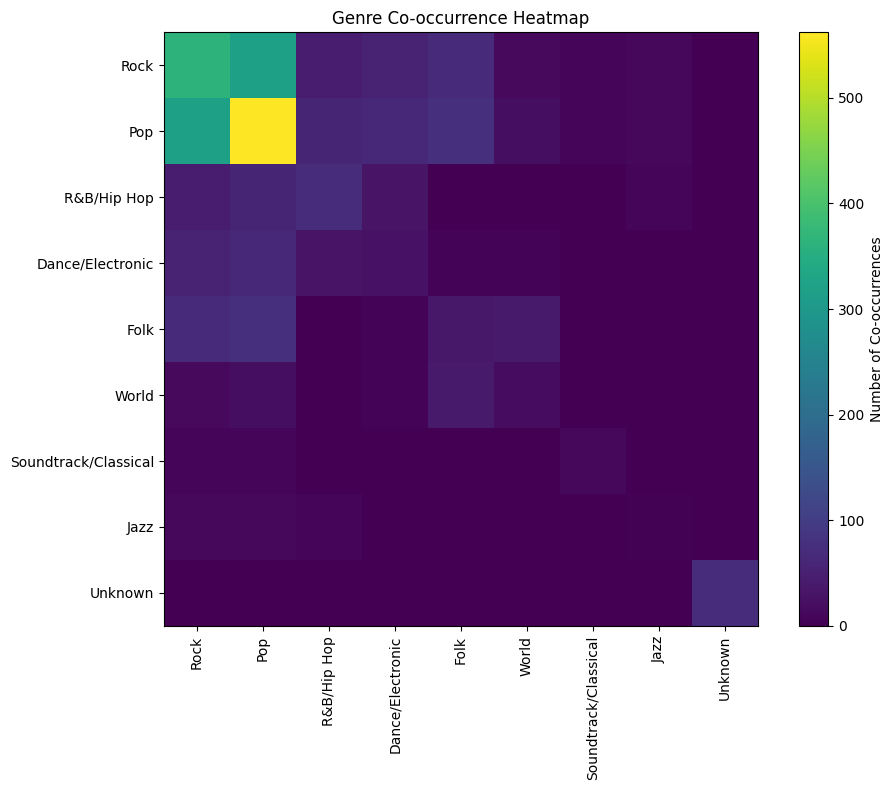

In [143]:
# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(co_occurrence_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Number of Co-occurrences')
plt.xticks(ticks=np.arange(len(all_genres)), labels=all_genres, rotation=90)
plt.yticks(ticks=np.arange(len(all_genres)), labels=all_genres)
plt.title('Genre Co-occurrence Heatmap')
plt.tight_layout()
plt.show()